## Time Series Forecasting for Sales
#### using XGBoost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df1= pd.read_csv('Super_Store_data.csv', encoding='latin1')

In [3]:
df = df1.loc[:, ['Order Date', 'Sales']]
df = df.set_index('Order Date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [4]:
df.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


<Axes: xlabel='Order Date'>

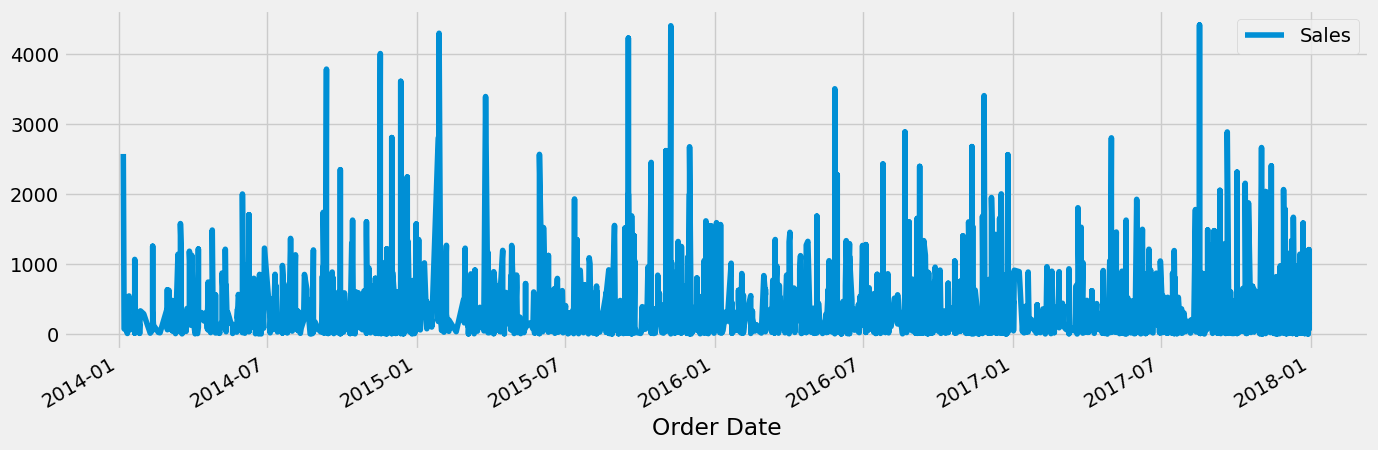

In [5]:
df.plot(figsize = (15,5))

<Axes: ylabel='Frequency'>

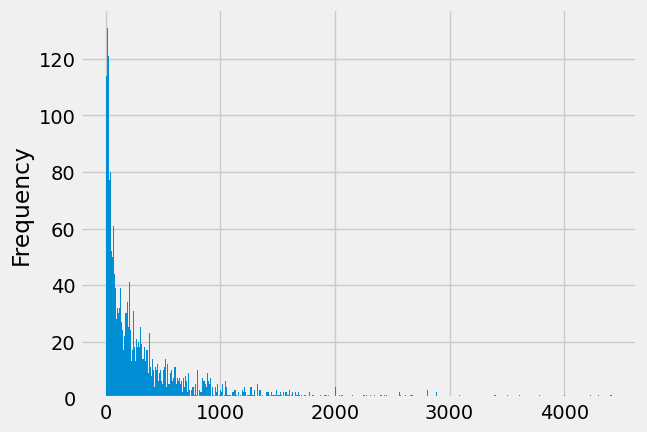

In [6]:
df['Sales'].plot(kind='hist', bins=500)

In [7]:

# Calculate the Z-scores of the 'Total' column
df['Z_score'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

# Define a Z-score threshold to identify outliers (e.g., 3 standard deviations from the mean)
z_threshold = 3

# Remove outliers
df = df[df['Z_score'].abs() <= z_threshold]
df= df.drop(columns=['Z_score'])
df.head()

,Sales
Order Date,
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940
2014-01-13,333.999


<Axes: xlabel='Order Date'>

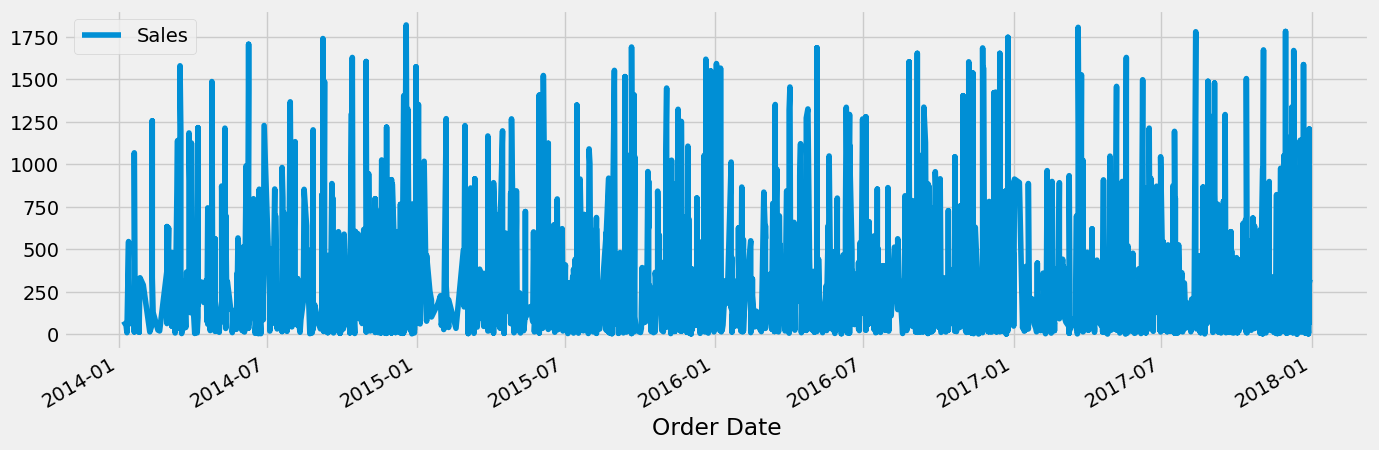

In [8]:
df.plot(figsize = (15,5))

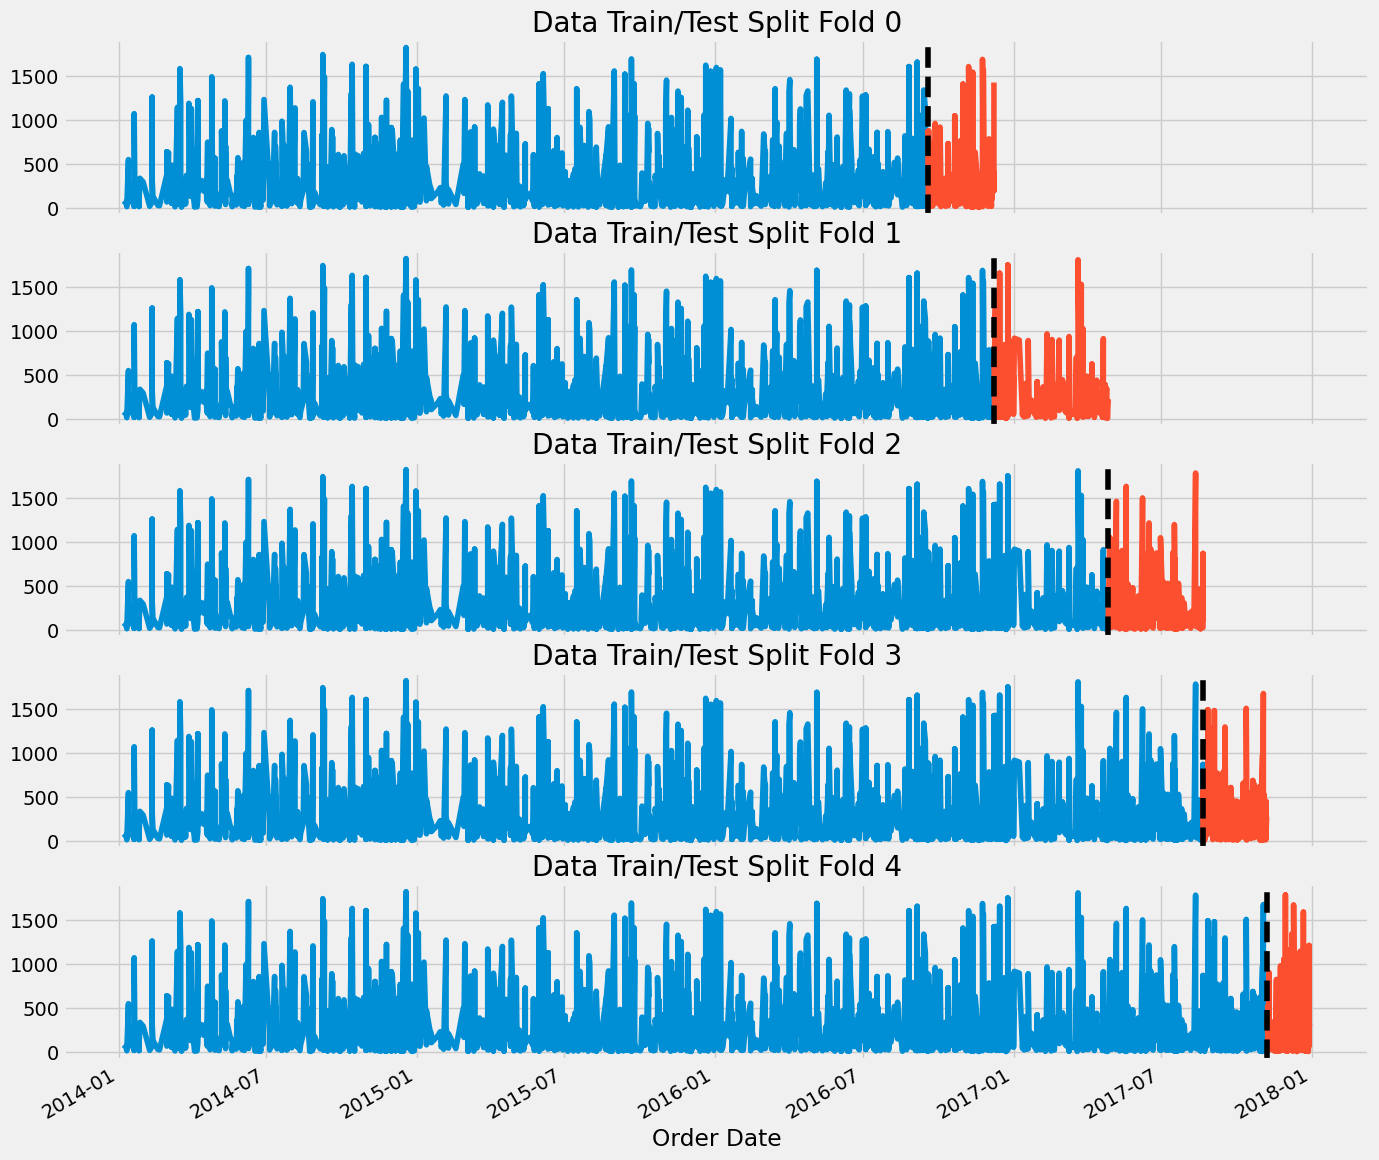

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=182, gap=1)
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Sales'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


In [11]:
def add_lags(df):
    df['lag1'] = df['Sales'].shift(91)
    df['lag2'] = df['Sales'].shift(182)
    df['lag3'] = df['Sales'].shift(364)
    return df

In [12]:
df = add_lags(df)

In [13]:
df.tail()

,Sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Order Date,,,,,,,,,,,,
2017-12-29,258.750,0,4,4,12,2017,363,29,52,242.352,127.372,40.480
2017-12-29,1207.840,0,4,4,12,2017,363,29,52,8.752,30.560,22.752
2017-12-29,101.120,0,4,4,12,2017,363,29,52,1159.056,449.568,866.400
2017-12-29,300.980,0,4,4,12,2017,363,29,52,701.960,28.272,388.704
2017-12-30,323.136,0,5,4,12,2017,364,30,52,521.960,272.970,91.920


In [14]:
df.head(184)

,Sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Order Date,,,,,,,,,,,,
2014-01-07,76.728,0,1,1,1,2014,7,7,2,NaN,NaN,NaN
2014-01-10,51.940,0,4,1,1,2014,10,10,2,NaN,NaN,NaN
2014-01-11,9.940,0,5,1,1,2014,11,11,2,NaN,NaN,NaN
2014-01-13,545.940,0,0,1,1,2014,13,13,3,NaN,NaN,NaN
2014-01-13,333.999,0,0,1,1,2014,13,13,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-08,121.376,0,4,3,8,2014,220,8,32,194.250,NaN,NaN
2014-08-11,12.350,0,0,3,8,2014,223,11,33,872.320,NaN,NaN
2014-08-12,85.440,0,1,3,8,2014,224,12,33,256.784,NaN,NaN


## XGBoost Forecasting

In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=182, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:470.28676	validation_1-rmse:459.64354
[100]	validation_0-rmse:368.49907	validation_1-rmse:368.71071
[200]	validation_0-rmse:347.00210	validation_1-rmse:356.56808
[297]	validation_0-rmse:338.74892	validation_1-rmse:356.43316


C:\Users\Mykhailo Kushnir\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:467.77423	validation_1-rmse:460.28594
[100]	validation_0-rmse:367.86042	validation_1-rmse:369.92599
[200]	validation_0-rmse:347.20993	validation_1-rmse:356.70013


C:\Users\Mykhailo Kushnir\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:339.69159	validation_1-rmse:356.51663
[310]	validation_0-rmse:339.09481	validation_1-rmse:356.66066
[0]	validation_0-rmse:468.26859	validation_1-rmse:424.88651
[100]	validation_0-rmse:368.93349	validation_1-rmse:340.92837
[200]	validation_0-rmse:349.43073	validation_1-rmse:331.09415
[300]	validation_0-rmse:342.22655	validation_1-rmse:330.51364
[303]	validation_0-rmse:342.05788	validation_1-rmse:330.51143


C:\Users\Mykhailo Kushnir\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:463.86419	validation_1-rmse:413.65912
[100]	validation_0-rmse:365.57799	validation_1-rmse:331.04299
[200]	validation_0-rmse:347.35866	validation_1-rmse:323.32373
[240]	validation_0-rmse:344.90136	validation_1-rmse:323.71977
[0]	validation_0-rmse:459.26776	validation_1-rmse:464.27764


C:\Users\Mykhailo Kushnir\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\Mykhailo Kushnir\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:362.83613	validation_1-rmse:377.94977
[200]	validation_0-rmse:344.84685	validation_1-rmse:363.89322
[300]	validation_0-rmse:339.59520	validation_1-rmse:361.03495
[337]	validation_0-rmse:338.32029	validation_1-rmse:361.46624


In [16]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 345.3224
Fold scores:[356.05812585344336, 356.0341814044459, 330.2715980475896, 323.2792225073287, 360.9690703179421]


In [17]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Sales'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:459.64504
[100]	validation_0-rmse:362.99646
[200]	validation_0-rmse:344.49432
[300]	validation_0-rmse:339.20423


C:\Users\Mykhailo Kushnir\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:335.27881
[499]	validation_0-rmse:331.60803


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [18]:
df.index.max()


Timestamp('2017-12-30 00:00:00')

In [19]:
# Create future dataframe
future = pd.date_range('2017-12-30','2019-01-01', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [20]:
future_w_features = df_and_future.query('isFuture').copy()


In [21]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

## Result
As a result we can see, that our model was able to to predict some realistic results only for the first next month. To solve this problem there is a need to try other models in order to improve prediction accuracy.

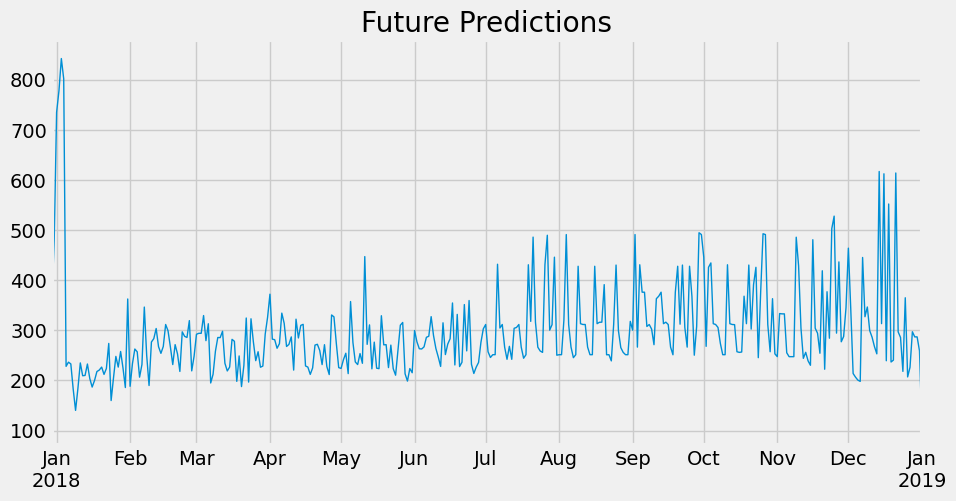

In [22]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()
